In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_no_lagrange, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=0)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=10000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=10)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=0, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=10, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=10000)

In [5]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = ds.preset_valuation_range(args.n_agents, args.n_items, dataset_name)
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds
).to(device)

train_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.num_examples, item_ranges).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [6]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)

  1%|          | 1/100 [01:44<2:51:52, 104.17s/it]

{'regret_max': 0.3707587718963623, 'regret_mean': 0.021471355110406876, 'regret_mults': tensor([[2.6275]], device='cuda:0'), 'payment': 0.3897453546524048}


  2%|▏         | 2/100 [03:31<2:51:51, 105.22s/it]

{'regret_max': 0.046218931674957275, 'regret_mean': 0.006822435650974512, 'regret_mults': tensor([[4.0155]], device='cuda:0'), 'payment': 0.4084179103374481}


  3%|▎         | 3/100 [05:28<2:55:33, 108.59s/it]

{'regret_max': 0.03129523992538452, 'regret_mean': 0.004293753299862146, 'regret_mults': tensor([[4.5042]], device='cuda:0'), 'payment': 0.410861611366272}


  4%|▍         | 4/100 [07:31<3:00:38, 112.90s/it]

{'regret_max': 0.026739180088043213, 'regret_mean': 0.003472074633464217, 'regret_mults': tensor([[5.5332]], device='cuda:0'), 'payment': 0.4114611744880676}


  5%|▌         | 5/100 [09:35<3:04:13, 116.35s/it]

{'regret_max': 0.020434290170669556, 'regret_mean': 0.002883177949115634, 'regret_mults': tensor([[6.3240]], device='cuda:0'), 'payment': 0.41010600328445435}


  6%|▌         | 6/100 [11:39<3:06:00, 118.73s/it]

{'regret_max': 0.03005540370941162, 'regret_mean': 0.0029356202576309443, 'regret_mults': tensor([[8.8060]], device='cuda:0'), 'payment': 0.4047781229019165}


  7%|▋         | 7/100 [13:47<3:07:57, 121.26s/it]

{'regret_max': 0.01617962121963501, 'regret_mean': 0.0018904183525592089, 'regret_mults': tensor([[9.4158]], device='cuda:0'), 'payment': 0.4035840928554535}


  8%|▊         | 8/100 [15:53<3:08:20, 122.83s/it]

{'regret_max': 0.015726447105407715, 'regret_mean': 0.001818022457882762, 'regret_mults': tensor([[11.5507]], device='cuda:0'), 'payment': 0.4019746482372284}


  9%|▉         | 9/100 [18:02<3:08:51, 124.52s/it]

{'regret_max': 0.02105116844177246, 'regret_mean': 0.0015941702295094728, 'regret_mults': tensor([[12.2971]], device='cuda:0'), 'payment': 0.40046411752700806}


 10%|█         | 10/100 [20:10<3:08:32, 125.69s/it]

{'regret_max': 0.016371488571166992, 'regret_mean': 0.0014263531193137169, 'regret_mults': tensor([[13.7191]], device='cuda:0'), 'payment': 0.39934203028678894}


 11%|█         | 11/100 [22:18<3:07:37, 126.48s/it]

{'regret_max': 0.016051113605499268, 'regret_mean': 0.0013591457391157746, 'regret_mults': tensor([[15.1407]], device='cuda:0'), 'payment': 0.3981948494911194}


 12%|█▏        | 12/100 [24:28<3:06:45, 127.34s/it]

{'regret_max': 0.022130489349365234, 'regret_mean': 0.0012781878467649221, 'regret_mults': tensor([[15.8448]], device='cuda:0'), 'payment': 0.39764970541000366}


 13%|█▎        | 13/100 [26:37<3:05:19, 127.81s/it]

{'regret_max': 0.016021311283111572, 'regret_mean': 0.001107168267481029, 'regret_mults': tensor([[16.4697]], device='cuda:0'), 'payment': 0.3970947861671448}


 14%|█▍        | 14/100 [28:45<3:03:39, 128.14s/it]

{'regret_max': 0.014227986335754395, 'regret_mean': 0.0010797664290294051, 'regret_mults': tensor([[16.8438]], device='cuda:0'), 'payment': 0.39688944816589355}


 15%|█▌        | 15/100 [30:55<3:02:03, 128.51s/it]

{'regret_max': 0.01166301965713501, 'regret_mean': 0.0009421052527613938, 'regret_mults': tensor([[18.7444]], device='cuda:0'), 'payment': 0.3966716527938843}


 16%|█▌        | 16/100 [33:04<3:00:11, 128.71s/it]

{'regret_max': 0.011644482612609863, 'regret_mean': 0.0009106075158342719, 'regret_mults': tensor([[19.9311]], device='cuda:0'), 'payment': 0.3957945704460144}


 17%|█▋        | 17/100 [35:12<2:57:51, 128.57s/it]

{'regret_max': 0.016508638858795166, 'regret_mean': 0.0009606927633285522, 'regret_mults': tensor([[21.1020]], device='cuda:0'), 'payment': 0.3949689269065857}


 18%|█▊        | 18/100 [37:19<2:54:46, 127.89s/it]

{'regret_max': 0.011811375617980957, 'regret_mean': 0.0008438486838713288, 'regret_mults': tensor([[22.2507]], device='cuda:0'), 'payment': 0.3942352533340454}


 19%|█▉        | 19/100 [39:25<2:51:54, 127.34s/it]

{'regret_max': 0.009638369083404541, 'regret_mean': 0.0007866907399147749, 'regret_mults': tensor([[22.9970]], device='cuda:0'), 'payment': 0.3938800096511841}


 20%|██        | 20/100 [41:31<2:49:27, 127.09s/it]

{'regret_max': 0.010308682918548584, 'regret_mean': 0.0007260072161443532, 'regret_mults': tensor([[24.1741]], device='cuda:0'), 'payment': 0.3933245539665222}


 21%|██        | 21/100 [43:36<2:46:32, 126.49s/it]

{'regret_max': 0.009932339191436768, 'regret_mean': 0.000725163146853447, 'regret_mults': tensor([[25.2035]], device='cuda:0'), 'payment': 0.39310646057128906}


 22%|██▏       | 22/100 [45:41<2:43:40, 125.90s/it]

{'regret_max': 0.008756875991821289, 'regret_mean': 0.000680645345710218, 'regret_mults': tensor([[27.0770]], device='cuda:0'), 'payment': 0.39226341247558594}


 23%|██▎       | 23/100 [47:47<2:41:33, 125.89s/it]

{'regret_max': 0.007955789566040039, 'regret_mean': 0.000586469832342118, 'regret_mults': tensor([[28.0341]], device='cuda:0'), 'payment': 0.3921177089214325}


 24%|██▍       | 24/100 [49:51<2:38:55, 125.47s/it]

{'regret_max': 0.01826387643814087, 'regret_mean': 0.0006640950450673699, 'regret_mults': tensor([[29.9978]], device='cuda:0'), 'payment': 0.391076922416687}


 25%|██▌       | 25/100 [51:56<2:36:29, 125.19s/it]

{'regret_max': 0.008720695972442627, 'regret_mean': 0.0005002904217690229, 'regret_mults': tensor([[31.7539]], device='cuda:0'), 'payment': 0.39122653007507324}


 26%|██▌       | 26/100 [53:58<2:33:18, 124.30s/it]

{'regret_max': 0.009484708309173584, 'regret_mean': 0.0005374272004701197, 'regret_mults': tensor([[32.7215]], device='cuda:0'), 'payment': 0.39041393995285034}


 27%|██▋       | 27/100 [55:58<2:29:47, 123.11s/it]

{'regret_max': 0.008790075778961182, 'regret_mean': 0.0004664827138185501, 'regret_mults': tensor([[33.4327]], device='cuda:0'), 'payment': 0.3904658555984497}


 28%|██▊       | 28/100 [58:00<2:27:06, 122.59s/it]

{'regret_max': 0.008796215057373047, 'regret_mean': 0.0004590705211739987, 'regret_mults': tensor([[33.8599]], device='cuda:0'), 'payment': 0.39020946621894836}


 29%|██▉       | 29/100 [1:00:00<2:24:13, 121.88s/it]

{'regret_max': 0.006907075643539429, 'regret_mean': 0.0003708956064656377, 'regret_mults': tensor([[35.4412]], device='cuda:0'), 'payment': 0.3902503550052643}


 30%|███       | 30/100 [1:01:59<2:21:26, 121.23s/it]

{'regret_max': 0.007045328617095947, 'regret_mean': 0.0003346405574120581, 'regret_mults': tensor([[36.4789]], device='cuda:0'), 'payment': 0.39017218351364136}


 31%|███       | 31/100 [1:04:03<2:20:02, 121.78s/it]

{'regret_max': 0.006393790245056152, 'regret_mean': 0.00032668240601196885, 'regret_mults': tensor([[37.2183]], device='cuda:0'), 'payment': 0.3899886906147003}


 32%|███▏      | 32/100 [1:06:01<2:16:53, 120.79s/it]

{'regret_max': 0.019344806671142578, 'regret_mean': 0.00047543650725856423, 'regret_mults': tensor([[37.7450]], device='cuda:0'), 'payment': 0.38752174377441406}


 33%|███▎      | 33/100 [1:08:01<2:14:30, 120.46s/it]

{'regret_max': 0.0066977739334106445, 'regret_mean': 0.0002450701722409576, 'regret_mults': tensor([[38.5497]], device='cuda:0'), 'payment': 0.38919714093208313}


 34%|███▍      | 34/100 [1:10:02<2:12:52, 120.80s/it]

{'regret_max': 0.0056656599044799805, 'regret_mean': 0.00022657637600786984, 'regret_mults': tensor([[38.8928]], device='cuda:0'), 'payment': 0.39027139544487}


 35%|███▌      | 35/100 [1:12:04<2:11:13, 121.13s/it]

{'regret_max': 0.008396327495574951, 'regret_mean': 0.000269671028945595, 'regret_mults': tensor([[39.2087]], device='cuda:0'), 'payment': 0.38975098729133606}


 36%|███▌      | 36/100 [1:14:05<2:09:09, 121.09s/it]

{'regret_max': 0.009472966194152832, 'regret_mean': 0.00027859254623763263, 'regret_mults': tensor([[39.8856]], device='cuda:0'), 'payment': 0.3894788920879364}


 37%|███▋      | 37/100 [1:16:06<2:07:11, 121.13s/it]

{'regret_max': 0.0072182416915893555, 'regret_mean': 0.0002466345322318375, 'regret_mults': tensor([[40.3730]], device='cuda:0'), 'payment': 0.38974058628082275}


 38%|███▊      | 38/100 [1:18:08<2:05:15, 121.22s/it]

{'regret_max': 0.00589984655380249, 'regret_mean': 0.0002332400472369045, 'regret_mults': tensor([[40.9474]], device='cuda:0'), 'payment': 0.39032459259033203}


 39%|███▉      | 39/100 [1:20:10<2:03:37, 121.61s/it]

{'regret_max': 0.005513936281204224, 'regret_mean': 0.0002353098097955808, 'regret_mults': tensor([[41.8948]], device='cuda:0'), 'payment': 0.39039909839630127}


 40%|████      | 40/100 [1:22:13<2:01:52, 121.87s/it]

{'regret_max': 0.006632506847381592, 'regret_mean': 0.0002397596836090088, 'regret_mults': tensor([[43.4417]], device='cuda:0'), 'payment': 0.3904721140861511}


 41%|████      | 41/100 [1:24:14<1:59:31, 121.55s/it]

{'regret_max': 0.017817020416259766, 'regret_mean': 0.00038618355756625533, 'regret_mults': tensor([[44.0758]], device='cuda:0'), 'payment': 0.38852837681770325}


 42%|████▏     | 42/100 [1:26:17<1:57:59, 122.06s/it]

{'regret_max': 0.006930530071258545, 'regret_mean': 0.00020904882694594562, 'regret_mults': tensor([[44.3129]], device='cuda:0'), 'payment': 0.38992607593536377}


 43%|████▎     | 43/100 [1:28:20<1:56:18, 122.43s/it]

{'regret_max': 0.008758902549743652, 'regret_mean': 0.00021934715914539993, 'regret_mults': tensor([[44.9956]], device='cuda:0'), 'payment': 0.3903777599334717}


 44%|████▍     | 44/100 [1:30:25<1:55:01, 123.25s/it]

{'regret_max': 0.009461283683776855, 'regret_mean': 0.00026485975831747055, 'regret_mults': tensor([[46.0248]], device='cuda:0'), 'payment': 0.3894641697406769}


 45%|████▌     | 45/100 [1:32:28<1:52:54, 123.17s/it]

{'regret_max': 0.006540179252624512, 'regret_mean': 0.00019580214575398713, 'regret_mults': tensor([[46.4039]], device='cuda:0'), 'payment': 0.3908950090408325}


 46%|████▌     | 46/100 [1:34:31<1:50:43, 123.03s/it]

{'regret_max': 0.0065615177154541016, 'regret_mean': 0.0002045512228505686, 'regret_mults': tensor([[46.7738]], device='cuda:0'), 'payment': 0.3901353180408478}


 47%|████▋     | 47/100 [1:36:34<1:48:37, 122.98s/it]

{'regret_max': 0.008488118648529053, 'regret_mean': 0.00020415737526491284, 'regret_mults': tensor([[49.0069]], device='cuda:0'), 'payment': 0.39102259278297424}


 48%|████▊     | 48/100 [1:38:36<1:46:16, 122.62s/it]

{'regret_max': 0.01008450984954834, 'regret_mean': 0.00028611026937142015, 'regret_mults': tensor([[49.9903]], device='cuda:0'), 'payment': 0.3884751796722412}


 49%|████▉     | 49/100 [1:40:39<1:44:20, 122.76s/it]

{'regret_max': 0.0068174004554748535, 'regret_mean': 0.0001956097548827529, 'regret_mults': tensor([[50.7668]], device='cuda:0'), 'payment': 0.3903174102306366}


 50%|█████     | 50/100 [1:42:42<1:42:29, 123.00s/it]

{'regret_max': 0.009363114833831787, 'regret_mean': 0.00019998841162305325, 'regret_mults': tensor([[51.7074]], device='cuda:0'), 'payment': 0.39006519317626953}


 51%|█████     | 51/100 [1:44:46<1:40:31, 123.09s/it]

{'regret_max': 0.007714688777923584, 'regret_mean': 0.00026288675144314766, 'regret_mults': tensor([[52.2362]], device='cuda:0'), 'payment': 0.3874567449092865}


 52%|█████▏    | 52/100 [1:46:50<1:38:45, 123.44s/it]

{'regret_max': 0.0078084468841552734, 'regret_mean': 0.0001882243377622217, 'regret_mults': tensor([[52.9799]], device='cuda:0'), 'payment': 0.3904223144054413}


 53%|█████▎    | 53/100 [1:48:55<1:37:02, 123.87s/it]

{'regret_max': 0.005621135234832764, 'regret_mean': 0.0001507248671259731, 'regret_mults': tensor([[53.2969]], device='cuda:0'), 'payment': 0.3911210894584656}


 54%|█████▍    | 54/100 [1:51:00<1:35:15, 124.25s/it]

{'regret_max': 0.006824374198913574, 'regret_mean': 0.00017980932898353785, 'regret_mults': tensor([[54.6784]], device='cuda:0'), 'payment': 0.3901466131210327}


 55%|█████▌    | 55/100 [1:53:04<1:33:15, 124.33s/it]

{'regret_max': 0.010042667388916016, 'regret_mean': 0.00018369199824519455, 'regret_mults': tensor([[55.1010]], device='cuda:0'), 'payment': 0.39046427607536316}


 56%|█████▌    | 56/100 [1:55:09<1:31:13, 124.40s/it]

{'regret_max': 0.008301019668579102, 'regret_mean': 0.0001679835404502228, 'regret_mults': tensor([[55.4856]], device='cuda:0'), 'payment': 0.39038604497909546}


 57%|█████▋    | 57/100 [1:57:14<1:29:22, 124.72s/it]

{'regret_max': 0.007556498050689697, 'regret_mean': 0.00018295698100700974, 'regret_mults': tensor([[56.4570]], device='cuda:0'), 'payment': 0.39013493061065674}


 58%|█████▊    | 58/100 [1:59:19<1:27:13, 124.62s/it]

{'regret_max': 0.009249329566955566, 'regret_mean': 0.00020262209000065923, 'regret_mults': tensor([[58.6802]], device='cuda:0'), 'payment': 0.38942524790763855}


 59%|█████▉    | 59/100 [2:01:23<1:25:07, 124.58s/it]

{'regret_max': 0.005523771047592163, 'regret_mean': 0.00014294825086835772, 'regret_mults': tensor([[59.1088]], device='cuda:0'), 'payment': 0.3909788131713867}


 60%|██████    | 60/100 [2:03:27<1:22:53, 124.33s/it]

{'regret_max': 0.007143378257751465, 'regret_mean': 0.00014540503616444767, 'regret_mults': tensor([[59.6402]], device='cuda:0'), 'payment': 0.3908642530441284}


 61%|██████    | 61/100 [2:05:31<1:20:43, 124.18s/it]

{'regret_max': 0.005526483058929443, 'regret_mean': 0.00015740931848995388, 'regret_mults': tensor([[60.3935]], device='cuda:0'), 'payment': 0.3907225728034973}


 62%|██████▏   | 62/100 [2:07:35<1:18:39, 124.21s/it]

{'regret_max': 0.0062454938888549805, 'regret_mean': 0.00016417374718002975, 'regret_mults': tensor([[61.2287]], device='cuda:0'), 'payment': 0.39011120796203613}


 63%|██████▎   | 63/100 [2:09:39<1:16:36, 124.22s/it]

{'regret_max': 0.008910834789276123, 'regret_mean': 0.00019798241555690765, 'regret_mults': tensor([[61.8965]], device='cuda:0'), 'payment': 0.3890608847141266}


 64%|██████▍   | 64/100 [2:11:39<1:13:40, 122.79s/it]

{'regret_max': 0.029138028621673584, 'regret_mean': 0.0005343375960364938, 'regret_mults': tensor([[62.2479]], device='cuda:0'), 'payment': 0.3827303647994995}


 65%|██████▌   | 65/100 [2:13:42<1:11:37, 122.78s/it]

{'regret_max': 0.006323695182800293, 'regret_mean': 0.00012908308417536318, 'regret_mults': tensor([[63.1708]], device='cuda:0'), 'payment': 0.3902812600135803}


 66%|██████▌   | 66/100 [2:15:46<1:09:47, 123.17s/it]

{'regret_max': 0.005225956439971924, 'regret_mean': 0.00011541691492311656, 'regret_mults': tensor([[63.5529]], device='cuda:0'), 'payment': 0.3911765217781067}


 67%|██████▋   | 67/100 [2:17:50<1:07:55, 123.50s/it]

{'regret_max': 0.00625079870223999, 'regret_mean': 0.0001156026846729219, 'regret_mults': tensor([[64.5125]], device='cuda:0'), 'payment': 0.3906112313270569}


 68%|██████▊   | 68/100 [2:19:54<1:05:58, 123.71s/it]

{'regret_max': 0.005174040794372559, 'regret_mean': 0.00011634072143351659, 'regret_mults': tensor([[65.2754]], device='cuda:0'), 'payment': 0.3912036418914795}


 69%|██████▉   | 69/100 [2:21:58<1:03:58, 123.81s/it]

{'regret_max': 0.005413174629211426, 'regret_mean': 0.00012817533570341766, 'regret_mults': tensor([[65.5248]], device='cuda:0'), 'payment': 0.3908607065677643}


 70%|███████   | 70/100 [2:24:02<1:01:55, 123.85s/it]

{'regret_max': 0.005692958831787109, 'regret_mean': 0.00012369721662253141, 'regret_mults': tensor([[65.9298]], device='cuda:0'), 'payment': 0.3910064101219177}


 71%|███████   | 71/100 [2:26:07<1:00:01, 124.18s/it]

{'regret_max': 0.005986392498016357, 'regret_mean': 0.00013881392078474164, 'regret_mults': tensor([[66.4889]], device='cuda:0'), 'payment': 0.3908233046531677}


 72%|███████▏  | 72/100 [2:28:11<57:50, 123.96s/it]  

{'regret_max': 0.006452977657318115, 'regret_mean': 0.0001567112049087882, 'regret_mults': tensor([[67.7415]], device='cuda:0'), 'payment': 0.38997316360473633}


 73%|███████▎  | 73/100 [2:30:14<55:41, 123.77s/it]

{'regret_max': 0.007304191589355469, 'regret_mean': 0.00014324721996672451, 'regret_mults': tensor([[68.4528]], device='cuda:0'), 'payment': 0.39010530710220337}


 74%|███████▍  | 74/100 [2:32:17<53:33, 123.59s/it]

{'regret_max': 0.005974292755126953, 'regret_mean': 0.00013433003914542496, 'regret_mults': tensor([[68.8608]], device='cuda:0'), 'payment': 0.3902004361152649}


 75%|███████▌  | 75/100 [2:34:20<51:23, 123.35s/it]

{'regret_max': 0.006178736686706543, 'regret_mean': 0.00013075099559500813, 'regret_mults': tensor([[69.7866]], device='cuda:0'), 'payment': 0.3904135525226593}


 76%|███████▌  | 76/100 [2:36:23<49:15, 123.14s/it]

{'regret_max': 0.005617916584014893, 'regret_mean': 0.00012259829964023083, 'regret_mults': tensor([[70.1783]], device='cuda:0'), 'payment': 0.3906855583190918}


 77%|███████▋  | 77/100 [2:38:25<47:10, 123.08s/it]

{'regret_max': 0.008329987525939941, 'regret_mean': 0.00013531313743442297, 'regret_mults': tensor([[71.1774]], device='cuda:0'), 'payment': 0.39034998416900635}


 78%|███████▊  | 78/100 [2:40:29<45:07, 123.07s/it]

{'regret_max': 0.00591510534286499, 'regret_mean': 0.000111861401819624, 'regret_mults': tensor([[71.4197]], device='cuda:0'), 'payment': 0.391071081161499}


 79%|███████▉  | 79/100 [2:42:31<43:03, 123.02s/it]

{'regret_max': 0.005892813205718994, 'regret_mean': 0.0001400487672071904, 'regret_mults': tensor([[72.3013]], device='cuda:0'), 'payment': 0.38981544971466064}


 80%|████████  | 80/100 [2:44:35<41:00, 123.05s/it]

{'regret_max': 0.004816770553588867, 'regret_mean': 0.00012221609358675778, 'regret_mults': tensor([[73.2874]], device='cuda:0'), 'payment': 0.39092615246772766}


 81%|████████  | 81/100 [2:46:38<39:01, 123.22s/it]

{'regret_max': 0.009024858474731445, 'regret_mean': 0.00015824341971892864, 'regret_mults': tensor([[74.3270]], device='cuda:0'), 'payment': 0.38989129662513733}


 82%|████████▏ | 82/100 [2:48:42<37:00, 123.34s/it]

{'regret_max': 0.0099601149559021, 'regret_mean': 0.0001494761381763965, 'regret_mults': tensor([[75.0517]], device='cuda:0'), 'payment': 0.3887745141983032}


 83%|████████▎ | 83/100 [2:50:45<34:58, 123.43s/it]

{'regret_max': 0.005483686923980713, 'regret_mean': 9.526665962766856e-05, 'regret_mults': tensor([[76.8130]], device='cuda:0'), 'payment': 0.3912805914878845}


 84%|████████▍ | 84/100 [2:52:51<33:04, 124.04s/it]

{'regret_max': 0.0059165358543396, 'regret_mean': 0.0001125322887673974, 'regret_mults': tensor([[77.2609]], device='cuda:0'), 'payment': 0.3909640908241272}


 85%|████████▌ | 85/100 [2:54:56<31:03, 124.24s/it]

{'regret_max': 0.009768545627593994, 'regret_mean': 0.00016308703925460577, 'regret_mults': tensor([[77.7097]], device='cuda:0'), 'payment': 0.3883814215660095}


 86%|████████▌ | 86/100 [2:57:00<28:59, 124.25s/it]

{'regret_max': 0.0072029829025268555, 'regret_mean': 0.00013158697402104735, 'regret_mults': tensor([[79.3425]], device='cuda:0'), 'payment': 0.39035558700561523}


 87%|████████▋ | 87/100 [2:59:04<26:54, 124.20s/it]

{'regret_max': 0.005270183086395264, 'regret_mean': 0.00011228575021959841, 'regret_mults': tensor([[79.9636]], device='cuda:0'), 'payment': 0.3903191089630127}


 88%|████████▊ | 88/100 [3:01:08<24:48, 124.03s/it]

{'regret_max': 0.010310769081115723, 'regret_mean': 0.00013047193351667374, 'regret_mults': tensor([[80.3911]], device='cuda:0'), 'payment': 0.389639288187027}


 89%|████████▉ | 89/100 [3:03:11<22:42, 123.87s/it]

{'regret_max': 0.00505751371383667, 'regret_mean': 0.0001032603977364488, 'regret_mults': tensor([[81.0726]], device='cuda:0'), 'payment': 0.3904585540294647}


 90%|█████████ | 90/100 [3:05:15<20:38, 123.89s/it]

{'regret_max': 0.005656540393829346, 'regret_mean': 0.00011066904698964208, 'regret_mults': tensor([[81.8653]], device='cuda:0'), 'payment': 0.3906201422214508}


 91%|█████████ | 91/100 [3:07:19<18:35, 123.90s/it]

{'regret_max': 0.007118344306945801, 'regret_mean': 0.00013448111712932587, 'regret_mults': tensor([[82.3762]], device='cuda:0'), 'payment': 0.38872024416923523}


 92%|█████████▏| 92/100 [3:09:23<16:31, 123.99s/it]

{'regret_max': 0.005059003829956055, 'regret_mean': 0.00010346966155339032, 'regret_mults': tensor([[83.1884]], device='cuda:0'), 'payment': 0.3907355070114136}


 93%|█████████▎| 93/100 [3:11:27<14:27, 123.98s/it]

{'regret_max': 0.004990041255950928, 'regret_mean': 0.00011794481542892754, 'regret_mults': tensor([[84.7414]], device='cuda:0'), 'payment': 0.3899781107902527}


 94%|█████████▍| 94/100 [3:13:31<12:23, 124.00s/it]

{'regret_max': 0.007374763488769531, 'regret_mean': 0.00011108910257462412, 'regret_mults': tensor([[85.5287]], device='cuda:0'), 'payment': 0.39052197337150574}


 95%|█████████▌| 95/100 [3:15:35<10:19, 123.92s/it]

{'regret_max': 0.00645822286605835, 'regret_mean': 0.00010581969399936497, 'regret_mults': tensor([[85.9769]], device='cuda:0'), 'payment': 0.3902932107448578}


 96%|█████████▌| 96/100 [3:17:38<08:15, 123.80s/it]

{'regret_max': 0.006058037281036377, 'regret_mean': 0.00011472866754047573, 'regret_mults': tensor([[86.7384]], device='cuda:0'), 'payment': 0.3900655508041382}


 97%|█████████▋| 97/100 [3:19:41<06:10, 123.60s/it]

{'regret_max': 0.006769955158233643, 'regret_mean': 0.00012057577259838581, 'regret_mults': tensor([[88.3915]], device='cuda:0'), 'payment': 0.38976848125457764}


 98%|█████████▊| 98/100 [3:21:47<04:08, 124.24s/it]

{'regret_max': 0.009701371192932129, 'regret_mean': 0.00014812973677180707, 'regret_mults': tensor([[89.3241]], device='cuda:0'), 'payment': 0.3882436752319336}


 99%|█████████▉| 99/100 [3:23:50<02:03, 123.94s/it]

{'regret_max': 0.005449235439300537, 'regret_mean': 0.00010313662642147392, 'regret_mults': tensor([[89.8926]], device='cuda:0'), 'payment': 0.39015981554985046}


100%|██████████| 100/100 [3:25:53<00:00, 123.54s/it]

{'regret_max': 0.00591808557510376, 'regret_mean': 0.00010720983846113086, 'regret_mults': tensor([[91.1211]], device='cuda:0'), 'payment': 0.3899593949317932}
CPU times: user 3h 23min 51s, sys: 41 s, total: 3h 24min 32s
Wall time: 3h 25min 54s


In [6]:
dir_name = 'unit_1x2_0_1_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [8]:
model.save(dir_name)

In [9]:
model = DoubleNet.load(dir_name).to(device)

In [10]:
%%time
# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [01:10, 70.09s/it]

CPU times: user 1min 9s, sys: 225 ms, total: 1min 9s
Wall time: 1min 10s


{'payment_mean': 0.3965136408805847,
 'regret_mean': 0.0005593834212049842,
 'regret_max': 0.004025578498840332}

In [11]:
def unit_1x2_0_1_optimal_mechanism(bids):
    import math
    batch_size, n_agents, n_items = bids.shape
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((batch_size, n_agents))
    
    for i in range(batch_size):
        if bids[i, 0, 0] > bids[i, 0, 1] and bids[i, 0, 0] > math.sqrt(3) / 3:
            allocs[i, 0, 0] = 1.0
            allocs[i, 0, 1] = 0.0
            payments[i] = math.sqrt(3) / 3
        elif bids[i, 0, 1] > math.sqrt(3) / 3:
            allocs[i, 0, 0] = 0.0
            allocs[i, 0, 1] = 1.0
            payments[i] = math.sqrt(3) / 3
    return allocs, payments

opt_alloc, opt_payments = unit_1x2_0_1_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.3926)

In [20]:
train_alloc, train_pay = unit_1x2_0_1_optimal_mechanism(train_data)
train_pay.mean()

tensor(0.3853)

In [12]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
model.sinkhorn_rounds = 10
model.sinkhorn_epsilon = 5e-2

random_starts = [test_data]
for i in range(10):
    random_starts.append(ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [06:30, 390.42s/it]

CPU times: user 6min 27s, sys: 1.31 s, total: 6min 28s
Wall time: 6min 30s


{'payment_mean': 0.3965136408805847,
 'regret_mean': 0.0007187009905464947,
 'regret_max': 0.00417327880859375}

In [13]:
model.save(dir_name)

In [7]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [8]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1', fontsize=16)
    ax1.set_xlabel('v1', fontsize=16)
    ax1.set_ylabel('v2', fontsize=16)
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=[0,1,0,1], vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2', fontsize=16)
    ax2.set_xlabel('v1', fontsize=16)
    ax2.set_ylabel('v2', fontsize=16)
    
    # Plot optimals
    ax1.plot([math.sqrt(3) / 3, math.sqrt(3) / 3], [0, math.sqrt(3) / 3], 'k--')
    ax1.plot([math.sqrt(3) / 3, 1], [math.sqrt(3) / 3, 1], 'k--')
    
    ax2.plot([0, math.sqrt(3) / 3], [math.sqrt(3) / 3, math.sqrt(3) / 3], 'k--')
    ax2.plot([math.sqrt(3) / 3, 1], [math.sqrt(3) / 3, 1], 'k--')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

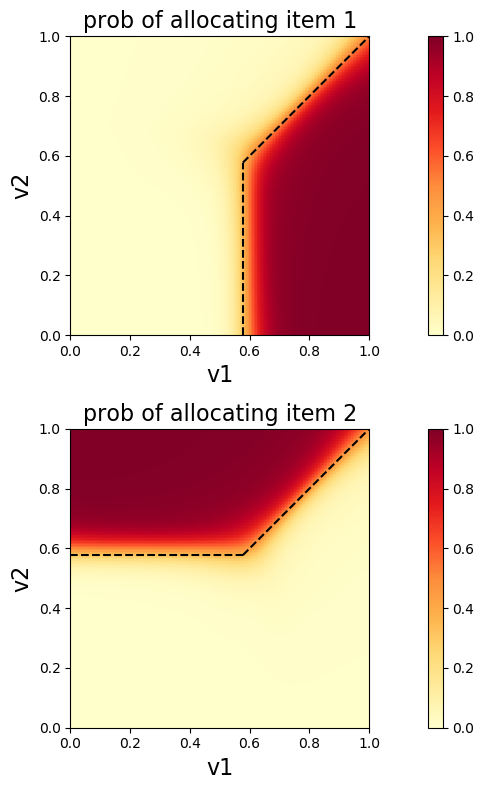

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
cpu_model.sinkhorn_rounds = 10
cpu_model.sinkhorn_epsilon = 5e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))
plt.savefig('unit_1x2_0_1_5_10_scaled.png')

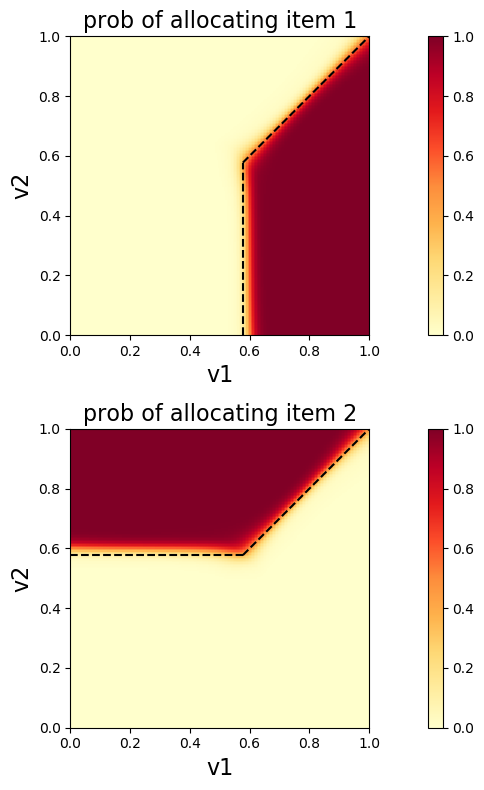

In [11]:
cpu_model.sinkhorn_rounds = 10
cpu_model.sinkhorn_epsilon = 2e-2
plot_12_model(cpu_model, 0.005, (0,1), (0,1))
plt.savefig('unit_1x2_0_1_2_10_scaled.png')

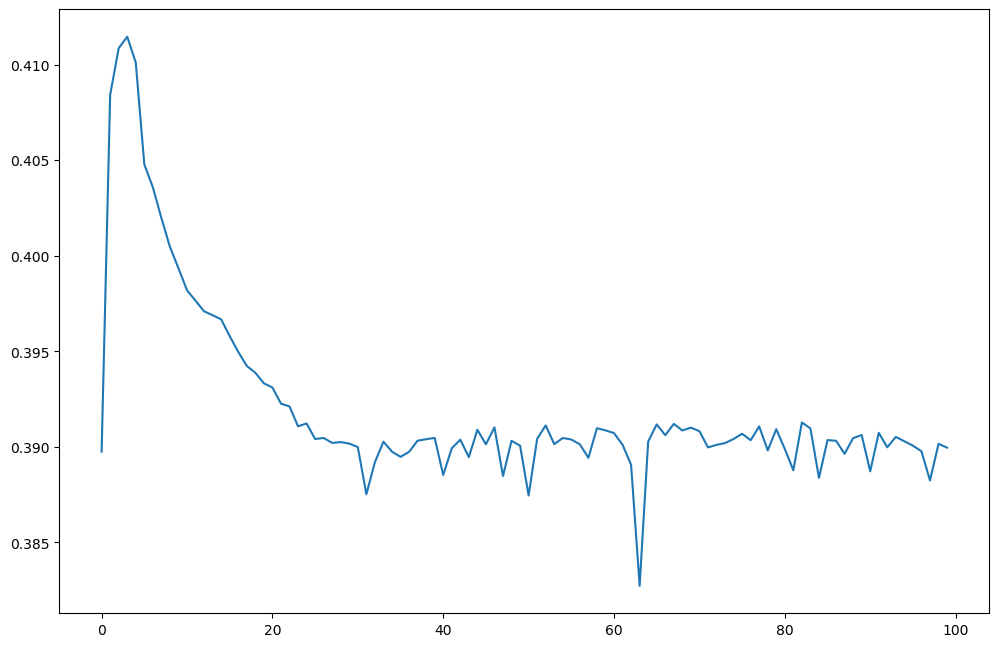

In [18]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [19]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)